# Statistics for low number of experimental repetitions

*Davi R. Ortega*

A common problem to make statistical tests in Biology. Each experiment is time consuming and more often than not, we see papers reporting bar plots with error bars calculated from n=3 experiments. Even worse is the use of parametric tests (tests that assume that the distribution of the data is normal) to validate statistical significance of differences in the averages when comparing two settings, each repeated three times.

Here, we will show:
*   How low sampling can be misleading
*   Better ways to report uncertainty
*   How parametric tests can be misleading
*   Better alternatives to "put a number" in how different are two sets of measurements.


Let's start from a hypothetical story that we know the real truth. Let's suppose that the entire population of four new species of bacteria that was discovered: **A** and **B**. Each population has a convenient number of 1000 cells. Now, we will characterize the cellular size of each species.


## Coding some Python

Below you will find a code that will allow us to create our environment of two populations of cells with different size distributions.

In [123]:
import numpy
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import scipy.stats as stats
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)
        
class Population (object):
    "Define the population class."
    def __init__(self, name, sizes = [], color = 'b'):
        "Initialize attributes"
        self.name = name
        self.sizes = numpy.array(sizes)
        self.aveSiz = numpy.average(sizes)
        self.sortSiz = numpy.sort(self.sizes)
        self.color = color
        self.stored = []

    def storeSample(self, n):
        "Initialize methods"
        self.stored = numpy.random.choice(self.sizes, n)
        return self.stored
    
    def showSum(self):
        import seaborn as sns
        import matplotlib.pyplot as plt

        sns.set(style="white", palette="muted", color_codes=True)
        f, axes = plt.subplots(1, 3, figsize=(10, 3))
        
        sns.distplot(self.sizes, kde=False, color=self.color, ax=axes[0], axlabel = 'hist')
        sns.violinplot(data = self.sizes, ax=axes[1], color=self.color)
        axes[2].plot(self.sortSiz, color=self.color)
        plt.show()

def compare(A, B):
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style="white", palette="muted", color_codes=True)
    
    AB = pandas.DataFrame({ A.name : A.sizes, B.name: B.sizes})
    ABmelt = pandas.melt(AB)
    ABmelt['sample'] = 'yes'
    f, axes = plt.subplots(1, 3, figsize=(10, 3), sharey = True)
    sns.violinplot(data = AB, ax=axes[0])
    sns.violinplot(data = ABmelt, ax=axes[1], split = True, x = 'sample', y = 'value', hue = 'variable', palette={ A.name: A.color, B.name: B.color})
    plt.show()    
    return AB

def makeDFfromSample(pops = []):
    sampleDF = {}
    for pop in pops:
        sampleDF[pop.name] = pop.stored
    sampleDF = pandas.DataFrame(sampleDF)
    sampleDFmelt = pandas.melt(sampleDF, var_name='Pop', value_name='size')
    return sampleDFmelt

def makeDFfromPops(pops = []):
    sampleDF = {}
    for pop in pops:
        sampleDF[pop.name] = pop.sizes
    sampleDF = pandas.DataFrame(sampleDF)
    sampleDFmelt = pandas.melt(sampleDF, var_name='Pop', value_name='size')
    return sampleDFmelt
    
def samplePops(pops = [], n = 3, printIt = True):
    for pop in pops:
        pop.storeSample(n)
        if printIt:
            print('Population {:s} => {:.2} +- {:.2}'.format(pop.name, pop.stored.mean(), pop.stored.std()))
    return None

def plotSample(pops = []):
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style="white", palette="muted", color_codes=True)
    stored = []
    for pop in pops:
        stored.append(pop.stored)
    f, axes = plt.subplots(1, 2, figsize=(10, 3), sharey = True)
    sns.barplot(data = stored, ax = axes[0])
    sns.swarmplot(data = stored, ax = axes[1])
    plt.show()

def makeSamplingExperiments(pops = [], num_samples = 3, n = 10, plotIt = True, printIt = True):
    results = []
    for i in range(n):
        if printIt:
            print('Executing the 3 measurements and ploting the results :: {:}'.format(i))
        samplePops(pops, num_samples, printIt = printIt)
        myANOVA = stats.f_oneway(pops[0].stored, pops[1].stored)
        if printIt:
            print('ANOVA p-value : {0:.2}\n'.format(myANOVA.pvalue))
        ABsamplesMelt = makeDFfromSample(pops)
        hsd = statsmodels.stats.multicomp.pairwise_tukeyhsd(ABsamplesMelt['size'],ABsamplesMelt['Pop'])
        if printIt:
            print('Tukey Honest Significant Difference: ')
            print(hsd)
        if plotIt:
            plotSample(pops)
        results.append({'pvalue': myANOVA.pvalue, 'TukeyHSD': hsd.reject[0]})
    return results

## Creating the populations of cells.

As anything in biology, sizes of organisms obey some distribution. Not all cells are exactly the same size. Here we will use the $\beta$ distribution to build a population of cell sizes.

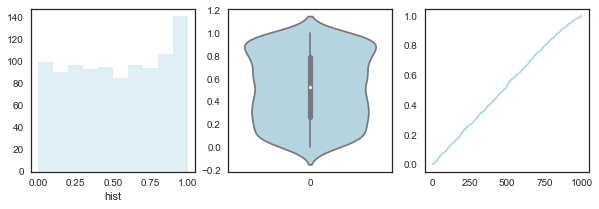

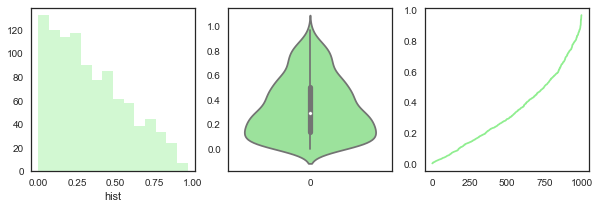

In [163]:
distrA = numpy.random.beta(1, 0.9, 1000)
A = Population(name = 'A', sizes = distrA, color = 'lightblue')
A.showSum()

distrB = numpy.random.beta(1, 2, 1000)
B = Population(name = 'B', sizes = distrB, color = 'lightgreen')
B.showSum()

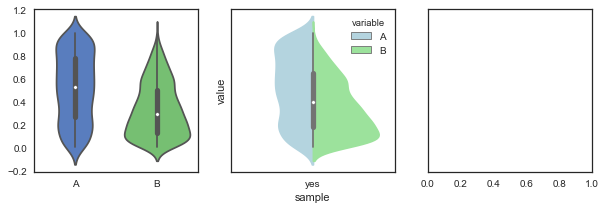

In [12]:
AB = compare(A, B)

We know that these two distributions are different, but just in case you wonder, let's use the tests to make sure it is true.

In [172]:
myANOVA = stats.f_oneway(A.sizes, B.sizes)
print('ANOVA p-value : {0:.2}\n'.format(myANOVA.pvalue))

myDFPops = makeDFfromPops([A,B])
hsd = statsmodels.stats.multicomp.pairwise_tukeyhsd(myDFPops['size'],myDFPops['Pop'])
print(hsd)

ANOVA p-value : 4.4e-53

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  A      B     -0.191  -0.2147 -0.1673  True 
---------------------------------------------


Notice how different the distribution of sizes are form the two samples. This is what we will consider the reality. Now let's make some measurements of the cell sizes in each population.

## Sampling the data

Now that we have our populations, let's randomnly measure 3 cells per population, because... you know... it is hard to measure cells.

Also, let's go ahead and measure the statistical significance using various tests:

* ANOVA (via the famous p-value >= 0.05)
* Tukey's Honest Significance Test

Executing the 3 measurements and ploting the results :: 0
Population A => 0.62 +- 0.31
Population B => 0.27 +- 0.16
ANOVA p-value : 0.23

Tukey Honest Significant Difference: 
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  A      B    -0.3467  -1.028 0.3346 False 
-------------------------------------------


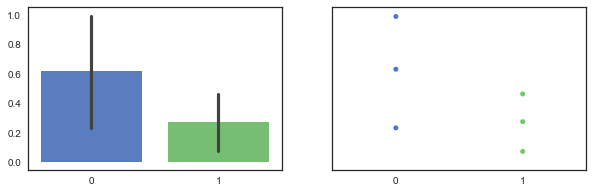

In [177]:
myResults = makeSamplingExperiments(pops = [A, B], num_samples = 3, n=1)

But since we are making an *in silica* experiment, let's do the drill to do the whole ordeal of measuring and calculating the statistics 1000 times. Let's skip printing the statistics and plots and just look at the results from the statistical tests.

Let's see if we get the same results every time. 

In [187]:
myResults = makeSamplingExperiments(pops = [A, B], num_samples = 50, n=1000, plotIt=False, printIt=False)
myResDF = pandas.DataFrame(myResults)
myResDF.groupby('TukeyHSD').count()

,pvalue
TukeyHSD,
False,67
True,933


In [128]:
myResults = makeSamplingExperiments(pops = [A, B], num_samples = 20, n=100, plotIt=False, printIt=False)
myResDF = pandas.DataFrame(myResults)
myResDF.groupby('TukeyHSD').count()

,TukeyHSD,pvalue
0,True,0.033429
1,True,0.001700
2,False,0.122172
3,True,0.006473
4,True,0.017822
5,False,0.063794
6,True,0.031164
7,False,0.206934
8,False,0.057713
9,False,0.104602


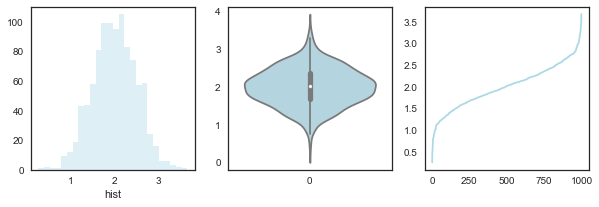

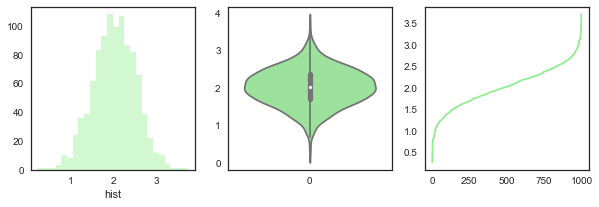

In [206]:
distrA = numpy.random.normal(2, 0.5, 1000)
A = Population(name = 'A', sizes = distrA, color = 'lightblue')
A.showSum()

distrB = numpy.random.normal(2, 0.5, 1000)
B = Population(name = 'B', sizes = distrB, color = 'lightgreen')
B.showSum()

Executing the 3 measurements and ploting the results :: 0
Population A => 1.9 +- 0.44
Population B => 2.2 +- 0.2
ANOVA p-value : 0.36

Tukey Honest Significant Difference: 
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  A      B     0.3546  -0.5995 1.3087 False 
--------------------------------------------


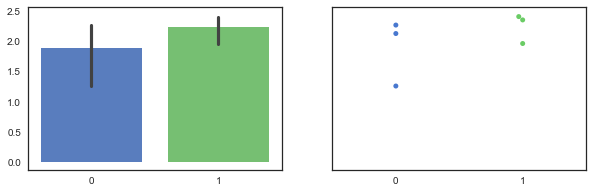

In [207]:
myResults = makeSamplingExperiments(pops = [A, B], num_samples = 3, n=1)

In [209]:
myResults = makeSamplingExperiments(pops = [A, B], num_samples = 3, n=1000, plotIt=False, printIt=False)
myResDF = pandas.DataFrame(myResults)
myResDF.groupby('TukeyHSD').count()

,pvalue
TukeyHSD,
False,943
True,57


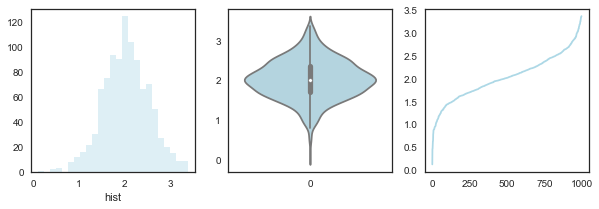

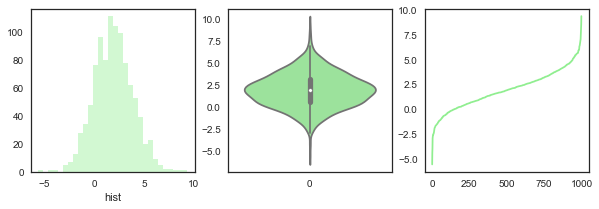

In [212]:
distrA = numpy.random.normal(2, 0.5, 1000)
A = Population(name = 'A', sizes = distrA, color = 'lightblue')
A.showSum()

distrB = numpy.random.normal(2, 2.0, 1000)
B = Population(name = 'B', sizes = distrB, color = 'lightgreen')
B.showSum()

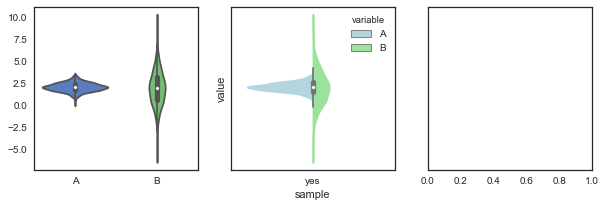

In [214]:
AB = compare(A, B)

In [235]:
myResults = makeSamplingExperiments(pops = [A, B], num_samples = 3, n=10000, plotIt=False, printIt=False)
myResDF = pandas.DataFrame(myResults)
myResDF.groupby('TukeyHSD').count()

,pvalue
TukeyHSD,
False,9125
True,875


In [159]:
myResults = makeSamplingExperiments(pops = [A, B], num_samples = 6, n=1000, plotIt=False, printIt=False)
myResDF = pandas.DataFrame(myResults)
myResDF.groupby('TukeyHSD').count()

,pvalue
TukeyHSD,
False,953
True,47


In [160]:
myResults = makeSamplingExperiments(pops = [A, B], num_samples = 10, n=1000, plotIt=False, printIt=False)
myResDF = pandas.DataFrame(myResults)
myResDF.groupby('TukeyHSD').count()

,pvalue
TukeyHSD,
False,946
True,54


In [162]:
myResults = makeSamplingExperiments(pops = [A, B], num_samples = 50, n=1000, plotIt=False, printIt=False)
myResDF = pandas.DataFrame(myResults)
myResDF.groupby('TukeyHSD').count()

,pvalue
TukeyHSD,
False,943
True,57
